# Solving TFI model with only 2 qubits - the 幺 simulation

### Reference: Variational Quantum Eigensolver with Fewer Qubits

*Jin-Guo Liu, Yi-Hong Zhang, Yuan Wan, Lei Wang*

https://arxiv.org/abs/1902.02663

In [368]:
using Yao
using Statistics: mean
using LinearAlgebra
using Plots

## Build a quantum circuit inspired by MPS

Hadamard Gate with dashed box is applied only when measuring on the X basis.
<div style="display:inline-block"><img style="float: left", src="images/hgate.png" width="50"/></div>

The following gates Measure and Reset a qubit to 0.

<div style="display:inline-block"><img style="float:left", src="images/mreset.png" width="100"></div>

The goal of this section is to build the MPS-inspired sampler as our ansatz

<div style="display:inline-block"><img style="float:left", src="images/twoqubit.png"></div>

In [369]:
rotor(noleading::Bool=false, notrailing::Bool=false) = noleading ? (notrailing ? Rx(0) : chain(Rx(0), Rz(0))) : (notrailing ? chain(Rz(0), Rx(0)) : chain(Rz(0), Rx(0), Rz(0)))

"""
    twoqubit_circuit(nlayer::Int, nrepeat::Int)

Construct the above ansatz, `nrepeat` is the number of measure operations,
`nlayer` is the length of each block.
"""
function twoqubit_circuit(nlayer::Int, nrepeat::Int)
    nbit_measure = nbit_virtual = 1
    nbit_used = nbit_measure + nbit_virtual
    circuit = chain(nbit_used)

    for i=1:nrepeat
        unit = chain(nbit_used)
        #push!(unit, put(nbit_used, 2=>H))
        for j=1:nlayer
            push!(unit, put(nbit_used, 1=>rotor(true, false)))
            push!(unit, put(nbit_used, 2=>H))
            push!(unit, put(nbit_used, 2=>Rz(0.0)))
            push!(unit, control(nbit_used, 1, 2=>shift(0.0)))
            if j == nlayer
                push!(unit, put(nbit_used, 1=>rotor(true, false)))
                push!(unit, put(nbit_used, 2=>H))
                push!(unit, put(nbit_used, 2=>Rz(0.0)))
            end
        end
        push!(unit, Measure{nbit_used, 1, AbstractBlock}(Z, (1,), 0, false))
        if i==nrepeat
            for k=2:nbit_used
                push!(unit, Measure{nbit_used, 1, AbstractBlock}(Z, (k,), 0, false))
            end
        end
        push!(circuit, unit)
    end
    dispatch!(circuit, :random)
end

twoqubit_circuit

In [370]:
circuit = twoqubit_circuit(1, 3)

nqubits: 2, datatype: Complex{Float64}
chain
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.21095863334236697)
│  │     └─ rot(Z gate, 0.7061513298045752)
│  ├─ put on (2)
│  │  └─ H gate
│  ├─ put on (2)
│  │  └─ rot(Z gate, 0.606758675085191)
│  ├─ control(1)
│  │  └─ (2,)shift(0.8692942974976297)
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.9742930709729192)
│  │     └─ rot(Z gate, 0.2511950574828521)
│  ├─ put on (2)
│  │  └─ H gate
│  ├─ put on (2)
│  │  └─ rot(Z gate, 0.8950395744932531)
│  └─ Measure{2,1,AbstractBlock}
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.8280959771285328)
│  │     └─ rot(Z gate, 0.6397794287466416)
│  ├─ put on (2)
│  │  └─ H gate
│  ├─ put on (2)
│  │  └─ rot(Z gate, 0.43658892015653006)
│  ├─ control(1)
│  │  └─ (2,)shift(0.22277943843476922)
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.6583878015555824)
│  │     └─ rot(Z gate, 0.054800922397594265)
│  ├─ put on (2)
│  │  └─ H gate
│ 

In [371]:
"""
    gensample(circuit, operator; nbatch=1024) -> Vector of Measure

Generate samples from MPS-inspired circuit. Here, `nbatch` means nshot.
`operator` is the operator to measure.
This function returns a vector of `Measure` gates, results are stored in `m.results`.
"""
function gensample(circuit, operator; nbatch=1024)
    mblocks = collect_blocks(Measure, circuit)
    for m in mblocks
        m.operator = operator
    end
    reg = zero_state(nqubits(circuit); nbatch=nbatch)
    reg |> circuit
    mblocks
end

gensample

In [372]:
res = gensample(circuit, X; nbatch=1024)

4-element Array{Measure,1}:
 Measure{2,1,AbstractBlock}
 Measure{2,1,AbstractBlock}
 Measure{2,1,AbstractBlock}
 Measure{2,1,AbstractBlock}

In [373]:
res[1].results

1024-element Array{Int64,1}:
  1
 -1
 -1
  1
  1
 -1
  1
  1
  1
  1
 -1
  1
  1
  ⋮
  1
  1
  1
  1
  1
 -1
  1
  1
 -1
  1
  1
  1

## Model Hamiltonians

### Transverse field Ising Model

$H = \sum\limits_{i=1}^{N-1} s_i^z s^z_{i+1} + h\sum\limits^{N}_{i=1} s_i^x$

where $s^\alpha = \frac 1 2 \sigma^\alpha$ is the spin operator.

In [374]:
"""
for simplicity, we require an AbstractModel contains `size` and `periodic` members.
"""
abstract type AbstractModel{D} end

nspin(model::AbstractModel) = prod(model.size)

nspin (generic function with 1 method)

In [375]:
"""
transverse field ising model, `h` is the strength of transverse field.
"""
struct TFI{D} <:AbstractModel{1}
    size::NTuple{D, Int}
    h::Float64
    periodic::Bool
    TFI(size::Int...; h::Real, periodic::Bool) = new{length(size)}(size, Float64(h), periodic)
end

TFI

In [376]:
function get_bonds(model::AbstractModel{1})
    nbit, = model.size
    [(i, i%nbit+1) for i in 1:(model.periodic ? nbit : nbit-1)]
end

function get_bonds(model::AbstractModel{2})
    m, n = model.size
    cis = LinearIndices(model.size)
    bonds = Tuple{Int, Int, Float64}[]
    for i=1:m, j=1:n
        (i!=m || model.periodic) && push!(bonds, (cis[i,j], cis[i%m+1,j]))
        (j!=n || model.periodic) && push!(bonds, (cis[i,j], cis[i,j%n+1]))
    end
    bonds
end

get_bonds (generic function with 2 methods)

In [377]:
function hamiltonian(model::TFI{1})
    nbit = nspin(model)
    sum(repeat(nbit, Z, (i,j)) for (i,j) in get_bonds(model))*0.25 +
    sum(put(nbit, i=>X) for i=1:nbit)*0.5model.h
end

hamiltonian (generic function with 2 methods)

In [378]:
tfi_model = TFI(4; h=0.5, periodic=false)

TFI{1}((4,), 0.5, false)

In [379]:
tfi_h = hamiltonian(tfi_model)

nqubits: 4, datatype: Complex{Float64}
sum
├─ [scale: 0.25] sum
│     ├─ repeat on (1, 2)
│     │  └─ Z gate
│     ├─ repeat on (2, 3)
│     │  └─ Z gate
│     └─ repeat on (3, 4)
│        └─ Z gate
└─ [scale: 0.25] sum
      ├─ put on (1)
      │  └─ X gate
      ├─ put on (2)
      │  └─ X gate
      ├─ put on (3)
      │  └─ X gate
      └─ put on (4)
         └─ X gate


Get the energy through sampling

In [380]:
function ising_energy(circuit, bonds, basis; nbatch=nbatch)
    mblocks = gensample(circuit, basis; nbatch=nbatch)
    nspin = length(mblocks)
    local eng = 0.0
    for (a, b) in bonds
        eng += mean(mblocks[a].results .* mblocks[b].results)
    end
    eng/=4
end

function energy(circuit, model::TFI; nbatch=1024)
    # measuring Z
    eng = ising_energy(circuit, get_bonds(model), Z; nbatch=nbatch)
    # measuring X
    mblocks = gensample(circuit, X; nbatch=nbatch)
    engx = sum(mean.([m.results for m in mblocks]))
    eng + model.h*engx/2
end

energy (generic function with 2 methods)

In [381]:
energy(circuit, tfi_model; nbatch=100000)

0.66818

### Heisenberg Model

$H = \sum\limits_{\alpha=x,y,z; i=1}^{N-1} s_i^\alpha s^\alpha_{i+1}$

where $s^\alpha = \frac 1 2 \sigma^\alpha$ is the spin operator.

In [382]:
struct Heisenberg{D} <: AbstractModel{D}
    size::NTuple{D, Int}
    periodic::Bool
    Heisenberg(size::Int...; periodic::Bool) = new{length(size)}(size, periodic)
end

In [330]:
heisenberg_ij(nbit::Int, i::Int, j::Int=i+1) = put(nbit, i=>X)*put(nbit, j=>X) + put(nbit, i=>Y)*put(nbit, j=>Y) + put(nbit, i=>Z)*put(nbit, j=>Z)
function hamiltonian(model::Heisenberg)
    nbit = nspin(model)
    sum(x->heisenberg_ij(nbit, x[1], x[2]), get_bonds(model))*0.25
end

hamiltonian (generic function with 2 methods)

The energy can be estimated through sampling

In [331]:
function energy(circuit, model::Heisenberg; nbatch=1024)
    bonds = get_bonds(model)
    sum(basis->ising_energy(circuit, bonds, basis; nbatch=nbatch), [X, Y, Z])
end

energy (generic function with 2 methods)

In [332]:
hei_model = Heisenberg(4; periodic=false)

Heisenberg{1}((4,), false)

In [350]:
energy(circuit, hei_model)

0.6640625

# Build the expanded view and check the energy

The expanded view is the equivalent model without qubit reusing, it is used for testing purpose.
From this circuit, we are able to obtain the ground state wave function directly.

<div style="display:inline-block"><img style="float:left", src="images/fourqubit.png"></div>

In [383]:
function expand_circuit(circuit)
    nbit = length(collect_blocks(Measure, circuit))
    nm = 1
    nv = 1
    c = chain(nbit)
    for (i, blk) in enumerate(circuit)
        blk = chain([b for b in blk if !(b isa Measure)]...)
        push!(c, concentrate(nbit, blk, [(i-1)*nm+1:i*nm..., nbit-nv+1:nbit...]))
    end
    c
end

expand_circuit (generic function with 1 method)

In [384]:
c_expand = expand_circuit(circuit)

nqubits: 4, datatype: Complex{Float64}
chain
├─ Concentrator: (1, 4)
│  └─ chain
│     ├─ put on (1)
│     │  └─ chain
│     │     ├─ rot(X gate, 0.21095863334236697)
│     │     └─ rot(Z gate, 0.7061513298045752)
│     ├─ put on (2)
│     │  └─ H gate
│     ├─ put on (2)
│     │  └─ rot(Z gate, 0.606758675085191)
│     ├─ control(1)
│     │  └─ (2,)shift(0.8692942974976297)
│     ├─ put on (1)
│     │  └─ chain
│     │     ├─ rot(X gate, 0.9742930709729192)
│     │     └─ rot(Z gate, 0.2511950574828521)
│     ├─ put on (2)
│     │  └─ H gate
│     └─ put on (2)
│        └─ rot(Z gate, 0.8950395744932531)
├─ Concentrator: (2, 4)
│  └─ chain
│     ├─ put on (1)
│     │  └─ chain
│     │     ├─ rot(X gate, 0.8280959771285328)
│     │     └─ rot(Z gate, 0.6397794287466416)
│     ├─ put on (2)
│     │  └─ H gate
│     ├─ put on (2)
│     │  └─ rot(Z gate, 0.43658892015653006)
│     ├─ control(1)
│     │  └─ (2,)shift(0.22277943843476922)
│     ├─ put on (1)
│     │  └─ chain
│     │     ├─

In [385]:
function wave_function(circuit)
    ec = chem2circuit(circuit)
    zero_state(nqubits(ec)) |> ec
end

wave_function (generic function with 1 method)

In [386]:
@show expect(tfi_h, wave_function(circuit)) |> real
@show expect(hamiltonian(hei_model), wave_function(circuit)) |> real;

expect(tfi_h, wave_function(circuit)) |> real = 0.6680718837003601
expect(hamiltonian(hei_model), wave_function(circuit)) |> real = 0.643674834586592


## Obtaining the ground state

Sequential optimization
1. obtain the gradient of one parameter a time $\frac{\partial E_\theta}{\partial \theta} = \frac 1 2 (E_{\theta+\pi/2}-E_{\theta-\pi/2})$
2. perform gradient descent update of this parameter $\theta\rightarrow \theta-\alpha \frac{\partial E_\theta}{\partial \theta}$
3. sweep all parameters until convergence.

In [387]:
function fidelity(circuit, VG)
    psi = zero_state(nqubits(circuit)) |> circuit
    abs(statevec(psi)' * VG)
end

fidelity (generic function with 1 method)

In [388]:
nparameters(circuit)

21

In [389]:
include("Adam.jl")
using QuAlgorithmZoo: Sequence

In [402]:
function train_adam(circuit, model; VG=nothing, maxiter=200, α=0.3, nbatch=1024)
    rots = Sequence(collect_blocks(Union{RotationGate, ControlBlock{<:Any, <:ShiftGate}}, circuit))
    c_expanded = expand_circuit(circuit)
    loss_history = Float64[]
    params = parameters(rots)
    grad = zero(params)
    optimizer = Adam(lr=α)
    for i in 0:maxiter
        for (j,r) in enumerate(rots.blocks)
            dispatch!(+, r, (π/2,))
            E₊ = energy(circuit, model; nbatch=nbatch)
            dispatch!(-, r, (π,))
            E₋ = energy(circuit, model; nbatch=nbatch)
            dispatch!(+, r, (π/2,))
            g = 0.5(E₊ - E₋)
            grad[j] = g
        end
        update!(params, grad, optimizer)
        dispatch!(rots, params)
        push!(loss_history, energy(circuit, model, nbatch=nbatch)/nspin(model))
        
        if i%10 == 0
            print("Iter $i, E/N = $(loss_history[end])")
            if !(VG isa Nothing)
                dispatch!(c_expanded, params)
                fid = fidelity(c_expanded, VG)
                println(", fidelity = $fid")
            else
                println()
            end
        end
    end
    loss_history, circuit
end

train_adam (generic function with 1 method)

In [403]:
lattice_size = 4
circuit = twoqubit_circuit(1, lattice_size-1)
model = TFI(lattice_size; h=0.5, periodic=false)
#model = Heisenberg(lattice_size; periodic=false)
h = hamiltonian(model)

nqubits: 4, datatype: Complex{Float64}
sum
├─ [scale: 0.25] sum
│     ├─ repeat on (1, 2)
│     │  └─ Z gate
│     ├─ repeat on (2, 3)
│     │  └─ Z gate
│     └─ repeat on (3, 4)
│        └─ Z gate
└─ [scale: 0.25] sum
      ├─ put on (1)
      │  └─ X gate
      ├─ put on (2)
      │  └─ X gate
      ├─ put on (3)
      │  └─ X gate
      └─ put on (4)
         └─ X gate


In [404]:
# obtain the exact ground state energy
res = eigen(mat(h) |> Matrix)
EG = res.values[1]/nspin(model)
@show EG
VG = res.vectors[:,1];

EG = -0.29742315519647605


In [405]:
nparameters(circuit)

21

In [421]:
dispatch!(circuit, :random)
loss_history, circuit = train_adam(circuit, model; maxiter=100, VG=VG, α=0.3);

Iter 0, E/N = 0.0726318359375, fidelity = 0.25845579205809155
Iter 10, E/N = -0.23974609375, fidelity = 0.6896265156498435
Iter 20, E/N = -0.2664794921875, fidelity = 0.760200799061576
Iter 30, E/N = -0.2786865234375, fidelity = 0.7791030293220049
Iter 40, E/N = -0.2747802734375, fidelity = 0.7858415810324807
Iter 50, E/N = -0.2720947265625, fidelity = 0.8229853040638265
Iter 60, E/N = -0.2752685546875, fidelity = 0.8136847347968759
Iter 70, E/N = -0.2801513671875, fidelity = 0.8093543532049662
Iter 80, E/N = -0.2799072265625, fidelity = 0.7981016468752032
Iter 90, E/N = -0.2847900390625, fidelity = 0.7999621873574618
Iter 100, E/N = -0.2757568359375, fidelity = 0.8092786873480131


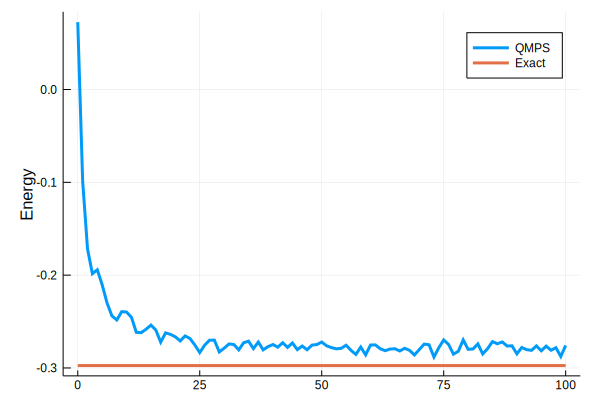

In [422]:
M = length(loss_history)
plot(0:M-1, [loss_history, fill(EG, M)], label=["QMPS", "Exact"], lw=3, ylabel="Energy")

In [423]:
circuit

nqubits: 2, datatype: Complex{Float64}
chain
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.07704615078670439)
│  │     └─ rot(Z gate, 1.9126587963726118)
│  ├─ put on (2)
│  │  └─ H gate
│  ├─ put on (2)
│  │  └─ rot(Z gate, 1.1683729798815674)
│  ├─ control(1)
│  │  └─ (2,)shift(-0.035768834905253795)
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 2.1742560988798867)
│  │     └─ rot(Z gate, -1.6010494730477072)
│  ├─ put on (2)
│  │  └─ H gate
│  ├─ put on (2)
│  │  └─ rot(Z gate, -1.4841550361270974)
│  └─ Measure{2,1,AbstractBlock}
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, -0.3877006786799756)
│  │     └─ rot(Z gate, -0.9338857822255419)
│  ├─ put on (2)
│  │  └─ H gate
│  ├─ put on (2)
│  │  └─ rot(Z gate, 2.182783352938954)
│  ├─ control(1)
│  │  └─ (2,)shift(0.25304518656007163)
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.9082957458769617)
│  │     └─ rot(Z gate, -1.9420436979852698)
│  ├─ put on (2)
│  │  └─ H ga

In [424]:
parameters(circuit)

21-element Array{Float64,1}:
  0.07704615078670439 
  1.9126587963726118  
  1.1683729798815674  
 -0.035768834905253795
  2.1742560988798867  
 -1.6010494730477072  
 -1.4841550361270974  
 -0.3877006786799756  
 -0.9338857822255419  
  2.182783352938954   
  0.25304518656007163 
  0.9082957458769617  
 -1.9420436979852698  
 -0.8952920962789711  
  0.7960753051963408  
  0.19729551473047033 
  2.684665952673796   
 -0.9983654336840248  
  1.9258925449011384  
 -0.7526389104264475  
 -0.37239572353900163 

# CMA-ES training method

In [410]:
include("CMAES.jl")

populate! (generic function with 1 method)

In [413]:
function cmaes_train(circuit, model; VG=nothing, maxiter=200, α=0.3, nbatch=1024)
    function loss(x)
        dispatch!(circuit, x)
        energy(circuit, model, nbatch=nbatch)/nspin(model)
    end
    
    ci = CMAESIter(loss, 0.1*rand(nparameters(circuit)), num_offsprings=50, num_parents=10)
    loss_history = Float64[]
    
    for (i, info) in enumerate(ci)
        push!(loss_history, best(info)[2])
        
        if i%10 == 0
            print("Iter $i, E/N = $(loss_history[end])")
            fid = fidelity(circuit |> expand_circuit, VG)
            println(VG isa Nothing ? "" : ", fidelity = $(fid)")
        end
        if i>=maxiter
            return loss_history, circuit
        else
            i += 1
        end
    end
end

cmaes_train (generic function with 1 method)

In [425]:
cmaes_train(circuit, model; VG=VG, maxiter=100, nbatch=2048);

Iter 10, E/N = -0.224365234375, fidelity = 0.4016444442803153
Iter 20, E/N = -0.2154541015625, fidelity = 0.5194804752680072
Iter 30, E/N = -0.2681884765625, fidelity = 0.607816455992811
Iter 40, E/N = -0.26885986328125, fidelity = 0.7720899526912559
Iter 50, E/N = -0.279296875, fidelity = 0.7633870627205673
Iter 60, E/N = -0.27374267578125, fidelity = 0.8302842081424706
Iter 70, E/N = -0.279541015625, fidelity = 0.7622259576741348
Iter 80, E/N = -0.27960205078125, fidelity = 0.8032809474897772
Iter 90, E/N = -0.28082275390625, fidelity = 0.7922344071776908
Iter 100, E/N = -0.2821044921875, fidelity = 0.7946279987623526


In [426]:
circuit

nqubits: 2, datatype: Complex{Float64}
chain
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, -4.167021865728496)
│  │     └─ rot(Z gate, 1.0644605325722671)
│  ├─ put on (2)
│  │  └─ H gate
│  ├─ put on (2)
│  │  └─ rot(Z gate, 1.2320907193580422)
│  ├─ control(1)
│  │  └─ (2,)shift(-0.00028005810715180796)
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.2699078188265768)
│  │     └─ rot(Z gate, 3.3900742879873613)
│  ├─ put on (2)
│  │  └─ H gate
│  ├─ put on (2)
│  │  └─ rot(Z gate, 1.7862479926101784)
│  └─ Measure{2,1,AbstractBlock}
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 3.893420214459148)
│  │     └─ rot(Z gate, -0.035473608664978167)
│  ├─ put on (2)
│  │  └─ H gate
│  ├─ put on (2)
│  │  └─ rot(Z gate, 3.079777822550059)
│  ├─ control(1)
│  │  └─ (2,)shift(-0.22295634214807386)
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 2.986370449844123)
│  │     └─ rot(Z gate, 4.690447909085334)
│  ├─ put on (2)
│  │  └─ H gate


In [427]:
parameters(circuit)

21-element Array{Float64,1}:
 -4.167021865728496     
  1.0644605325722671    
  1.2320907193580422    
 -0.00028005810715180796
  0.2699078188265768    
  3.3900742879873613    
  1.7862479926101784    
  3.893420214459148     
 -0.035473608664978167  
  3.079777822550059     
 -0.22295634214807386   
  2.986370449844123     
  4.690447909085334     
 -2.0210786251649675    
 -0.4795439065867406    
 -5.40022817865976      
 -1.1128380852547572    
  4.469973713686416     
 -2.237721876680651     
  2.190487959624729     
 -0.665311771966154     

## Entanglement Entropy

In [428]:
EV = eigen(mat(h) |> Matrix).vectors[:,1]

16-element Array{Complex{Float64},1}:
  0.10878394077769024 + 0.0im
  -0.1666666666666665 + 0.0im
 -0.25534814770632663 + 0.0im
  0.14656420692863603 + 0.0im
  -0.2553481477063265 + 0.0im
   0.4798975402619696 + 0.0im
  0.22454939255564377 + 0.0im
  -0.1666666666666668 + 0.0im
 -0.16666666666666657 + 0.0im
  0.22454939255564235 + 0.0im
  0.47989754026197007 + 0.0im
  -0.2553481477063253 + 0.0im
    0.146564206928636 + 0.0im
  -0.2553481477063251 + 0.0im
  -0.1666666666666669 + 0.0im
  0.10878394077768962 - 0.0im

In [429]:
reg = ArrayReg(EV)

ArrayReg{1, Complex{Float64}, Array...}
    active qubits: 4/4

In [430]:
r = reg |> focus!(1, 2) |> ρ

DensityMatrix{1,Complex{Float64},Array{Complex{Float64},3}}
    active qubits: 2/2

In [431]:
entropy(spectrum) = -sum(spectrum .* log.(spectrum))/log(2)

entropy (generic function with 1 method)

In [432]:
entropy(eigen(r.state[:,:,1]).values)

0.41098665651454297